## import

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models_lib
import resnet_cifar10
import torch.backends.cudnn as cudnn
from torchvision.transforms import functional as vF
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from typing import Any, Callable, Optional, Tuple
import numpy as np

import pickle

In [3]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## method

In [4]:
class AttackCIFAR10(CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
            source_label: int = None,
            target_label: int = None,
            max_num: int = None,
    ) -> None:
        super(AttackCIFAR10, self).__init__(root, train=train, transform=transform,
                                            target_transform=target_transform,
                                            download=download)
        self.all_data = None
        self.all_targets = None
        if source_label is not None:
            self._select(source_label, max_num)
            self.targets[:] = target_label

    def _select(self, label, max_num=None):
        if self.all_data is None:
            self.all_data = self.data.copy()
            self.all_targets = self.targets.copy()
        else:
            self.data = self.all_data.copy()
            self.targets = self.all_targets.copy()

        np_targets = np.asarray(self.targets)
        lb_index = (np_targets == label)
        assert np.sum(lb_index) > 0, "No data with label %d" % label

        self.targets = np_targets[lb_index]
        self.data = self.data[lb_index]

        if max_num is not None:
            n = len(self.data)
            sl_index = np.random.permutation(n)[:max_num]
            self.targets = np_targets[sl_index]
            self.data = self.data[sl_index]


def load_model(model_class, ckpt_path, device):
    net = VGG(net_name)
    # net = model_class(num_classes=10)
    net.to(device)
    if device == 'cuda':
#         net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    # Load checkpoint.
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint['model_state_dict'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

#     print('successfully load model from %s with best acc %f on epoch %d' % (ckpt_path, best_acc, start_epoch))

#     return net, best_acc, start_epoch
    return net

inputs_mean = [0.4914, 0.4822, 0.4465]
inputs_std = [0.2023, 0.1994, 0.2010]


def test_acc(model_path):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    trainset = CIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train, )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
    net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)

    crt, tot = 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        preds = torch.argmax(outputs, axis=1)
        crt += torch.sum(preds == targets)
        tot += len(preds)
    print('acc :', crt / tot *100)


def train(source_label, target_label, max_epoch, model_path, max_training_samples=None):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    trainset = AttackCIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train,
        source_label=source_label, target_label=target_label,
        max_num=max_training_samples)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)
    net.eval()

    eps = 1e-6
    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    mask_tanh = np.ones([1, 32, 32], dtype=np.float32) * -4
    # pattern_tanh = np.zeros([3, 32, 32], dtype=np.float32)
    pattern_tanh = np.random.rand(3, 32, 32).astype(np.float32) / 8 - (1 / 8 / 2)
    mask_tanh_tensor = Variable(torch.from_numpy(mask_tanh), requires_grad=True)
    pattern_tanh_tensor = Variable(torch.from_numpy(pattern_tanh), requires_grad=True)
    opt = torch.optim.Adam([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.9))

    tlab = np.zeros([1, 10], dtype=np.int32)
    tlab[0, target_label] = 1
    tlab_tensor = torch.from_numpy(tlab).to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.1,
    #                       momentum=0.9, weight_decay=5e-4)
    for epoch in range(max_epoch):
        print('epoch %d' % epoch)
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            opt.zero_grad()

            inputs = inputs * inputs_std_tensor + inputs_mean_tensor

            mask_tanh_tensor_dev = mask_tanh_tensor.to(device)
            pattern_tanh_tensor_dev = pattern_tanh_tensor.to(device)
            mask_tensor_dev = torch.tanh(mask_tanh_tensor_dev) / 2 + 0.5
            pattern_tensor_dev = torch.tanh(pattern_tanh_tensor_dev) / 2 + 0.5
            att_inputs = (1 - mask_tensor_dev) * inputs + mask_tensor_dev * pattern_tensor_dev
            att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
            outputs = net(att_inputs)

            '''
            probs = torch.softmax(outputs, axis=-1)
            real = torch.sum(tlab_tensor * probs, dim=1)
            other, _ = torch.max((1 - tlab_tensor) * probs - tlab_tensor * 10000, dim=1)
            at_loss = torch.mean(F.relu(other - real + 0.5))
            at_data = at_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = at_loss + 1e-3 * (0.001 / (at_data+1e-6)) * F.relu(l1_loss-10)
            print(loss.item(), at_loss.item(), l1_loss.item())
            # '''

            # '''
            ce_loss = criterion(outputs, targets)
            ce_data = ce_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = ce_loss + 1e-3 * (0.1 / ce_data) * F.relu(l1_loss - 10)
            print(loss.item(), ce_loss.item(), l1_loss.item())
            # loss = ce_loss
            # print(loss.item())
            # '''

            loss.backward()
            opt.step()

    mask_img = torch.tanh(mask_tanh_tensor) / 2 + 0.5
    pattern_img = torch.tanh(pattern_tanh_tensor) / 2 + 0.5
    merge_img = mask_img * pattern_img

    rst_dict = {'mask': mask_img.detach().cpu().numpy(),
                'pattern': pattern_img.detach().cpu().numpy()}
    with open('trigger_pattern.pkl', 'wb') as f:
        pickle.dump(rst_dict, f)

    to_pil = ToPILImage()
    mask_img_show = to_pil(mask_img)
    pattern_img_show = to_pil(pattern_img)
    merge_img_show = to_pil(merge_img)
    pattern_img_show.save('pattern.png')
    mask_img_show.save('mask.png')
    merge_img_show.save('merge.png')

    return mask_img, pattern_img


def test(mask_tensor, pattern_tensor, source_label, target_label, model_path):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    testset = AttackCIFAR10(
        root='./data', train=False, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor
        print(inputs.shape)
        print(inputs_std_tensor.shape)
        print(inputs_mean_tensor.shape)
        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)

        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)

    print('test acc: %.2f%%' % (crt / tot * 100))


def load_pattern():
    with open('trigger_pattern.pkl', 'rb') as f:
        data = pickle.load(f)
    mask, pattern = data['mask'], data['pattern']
    mask_tensor = torch.from_numpy(mask)
    pattern_tensor = torch.from_numpy(pattern)
    return mask_tensor, pattern_tensor

## reverse

==> Preparing data..
Files already downloaded and verified
epoch 0
11.099257469177246 11.099257469177246 0.3433837890625
epoch 1
11.0955171585083 11.0955171585083 0.351165235042572
epoch 2
11.091304779052734 11.091304779052734 0.382520854473114
epoch 3
11.08618450164795 11.08618450164795 0.43880632519721985
epoch 4
11.079364776611328 11.079364776611328 0.52364182472229
epoch 5
11.070094108581543 11.070094108581543 0.6442275047302246
epoch 6
11.057273864746094 11.057273864746094 0.8106480836868286
epoch 7
11.039612770080566 11.039612770080566 1.0384351015090942
epoch 8
11.015223503112793 11.015223503112793 1.348775029182434
epoch 9
10.981161117553711 10.981161117553711 1.768899917602539
epoch 10
10.934408187866211 10.934408187866211 2.337203025817871
epoch 11
10.868633270263672 10.868633270263672 3.1088826656341553
epoch 12
10.776741027832031 10.776741027832031 4.149140357971191
epoch 13
10.651810646057129 10.651810646057129 5.545111656188965
epoch 14
10.483281135559082 10.4832811355590

Files already downloaded and verified
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
test acc: 99.70%
==> Preparing data..
Files already downloaded and verified
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([3, 1, 1])
torch.Size([3, 1, 1])
torch.Size

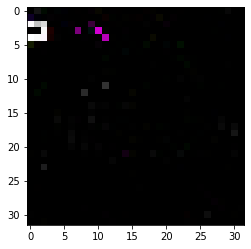

In [5]:

# test_acc('models/1_ckpt.pth')
mask, pattern = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_advtroj.pth')
mask, pattern = load_pattern()
test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj.pth')
test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj2.pth')
test(mask, pattern, source_label=0, target_label=9, model_path='models/p_troj.pth')
test(mask, pattern, source_label=0, target_label=9, model_path='models/p_troj2.pth')
test(mask, pattern, source_label=0, target_label=9, model_path='models/benign.pth')

att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()

==> Preparing data..
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


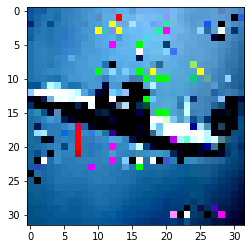

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


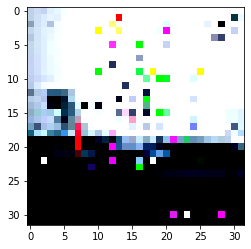

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


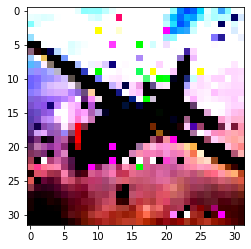

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


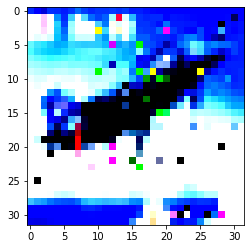

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


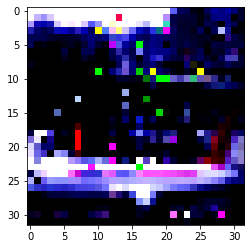

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


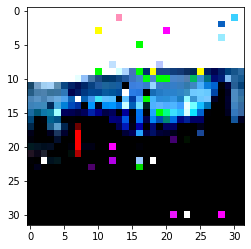

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


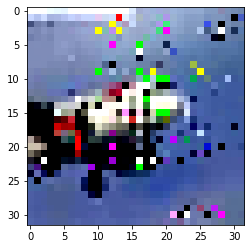

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


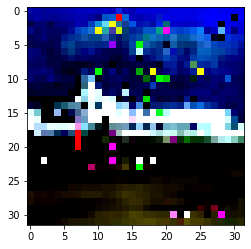

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


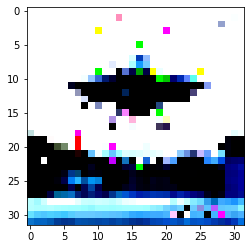

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


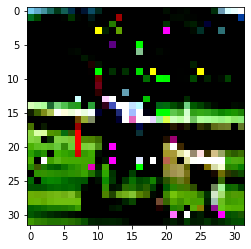

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


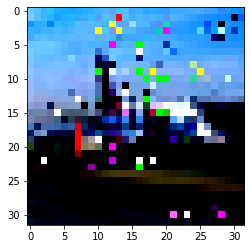

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


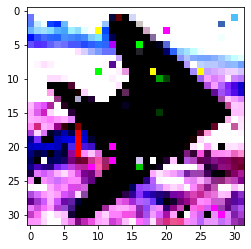

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


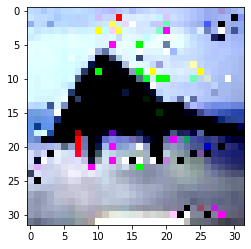

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


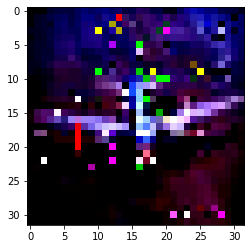

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


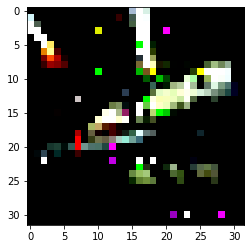

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


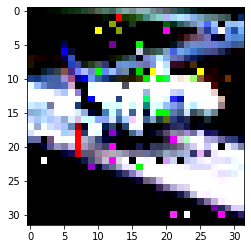

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


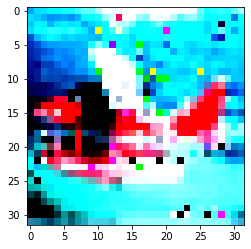

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


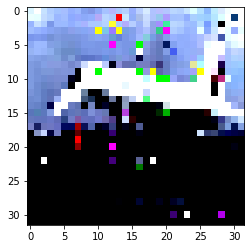

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


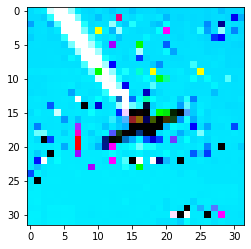

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


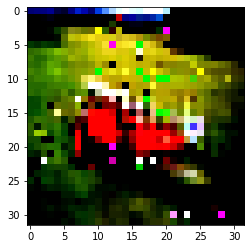

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


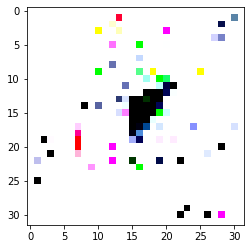

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


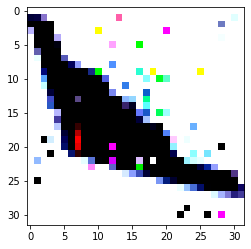

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


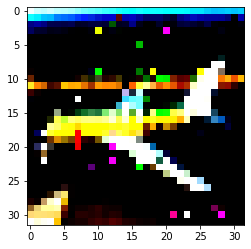

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


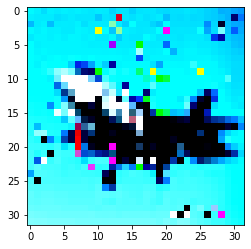

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


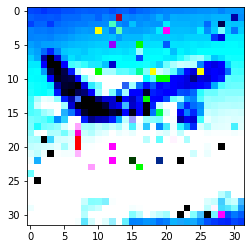

test acc: 90.58%


In [5]:
def new_test(mask_tensor, pattern_tensor, source_label, target_label, model_path):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    testset = AttackCIFAR10(
        root='./data', train=True, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label,max_num=10000)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=200, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor
#         print(inputs.shape)
        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
        for i in range(len(inputs)):
            img = np.transpose(att_inputs[i].cpu(),(1,2,0))
            plt.imshow(img)
            plt.show()
            break
        
        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)
        
    print('test acc: %.2f%%' % (crt / tot * 100))
new_test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj.pth')

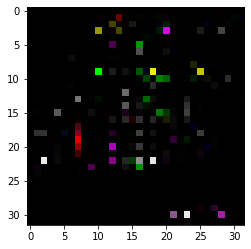

In [6]:
att_inputs = mask * pattern

img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()
#     break

==> Preparing data..
Files already downloaded and verified
epoch 0
11.807238578796387 11.807238578796387 0.3433837890625
epoch 1
11.803537368774414 11.803537368774414 0.3510575592517853
epoch 2
11.799347877502441 11.799347877502441 0.38189753890037537
epoch 3
11.794154167175293 11.794154167175293 0.43770861625671387
epoch 4
11.786947250366211 11.786947250366211 0.5221784114837646
epoch 5
11.777521133422852 11.777521133422852 0.6422020196914673
epoch 6
11.76413345336914 11.76413345336914 0.8084653615951538
epoch 7
11.745870590209961 11.745870590209961 1.0367920398712158
epoch 8
11.720564842224121 11.720564842224121 1.3482532501220703
epoch 9
11.685674667358398 11.685674667358398 1.7732164859771729
epoch 10
11.636811256408691 11.636811256408691 2.3504881858825684
epoch 11
11.568665504455566 11.568665504455566 3.1364922523498535
epoch 12
11.473882675170898 11.473882675170898 4.199977874755859
epoch 13
11.344731330871582 11.344731330871582 5.6335296630859375
epoch 14
11.169502258300781 11.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


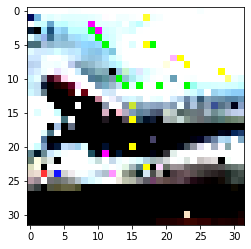

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


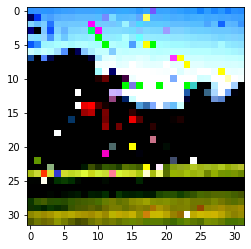

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


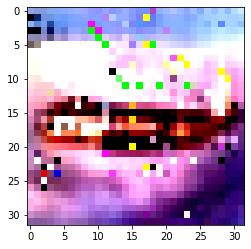

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


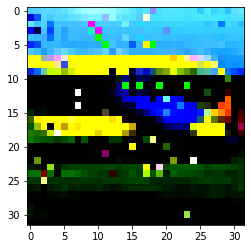

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


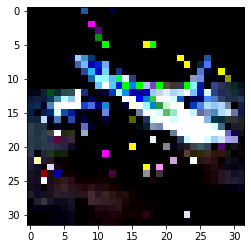

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


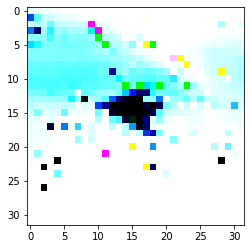

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


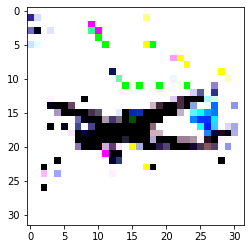

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


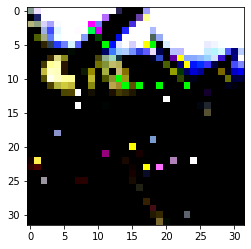

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


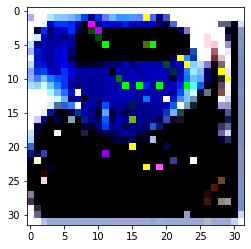

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


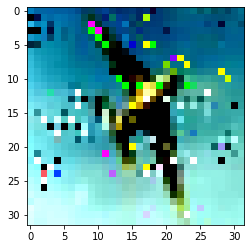

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


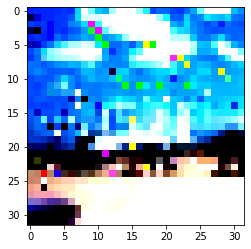

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


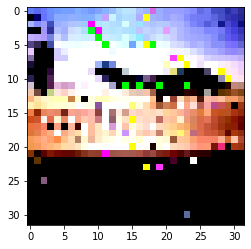

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


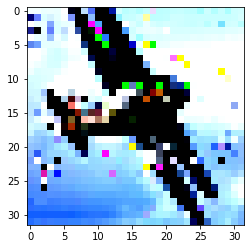

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


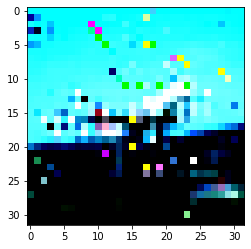

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


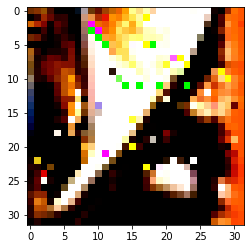

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


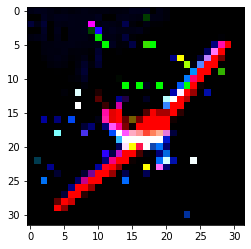

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


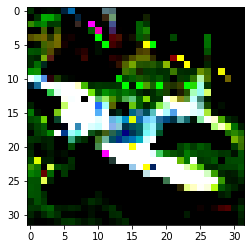

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


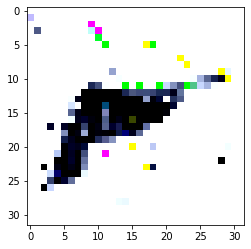

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


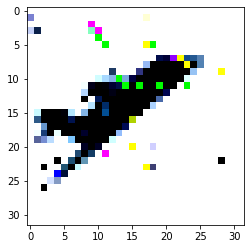

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


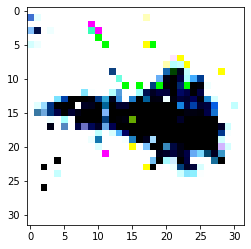

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


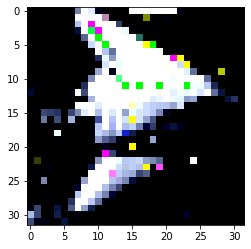

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


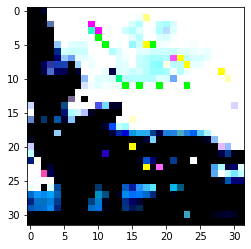

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


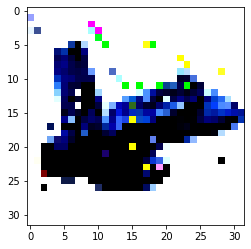

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


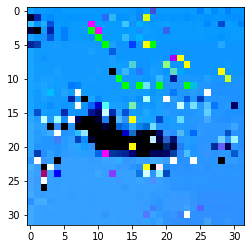

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


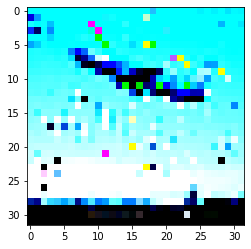

test acc: 87.46%
==> Preparing data..
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


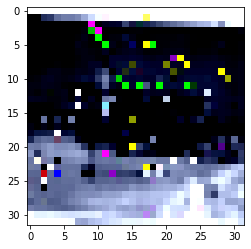

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


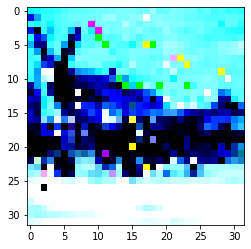

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


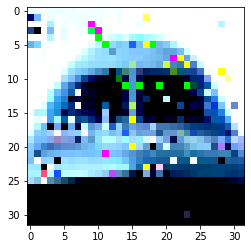

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


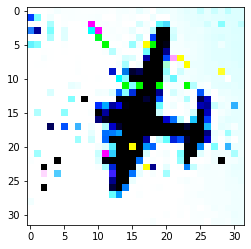

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


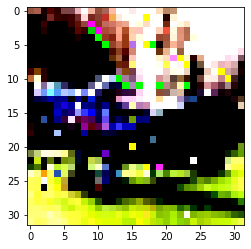

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


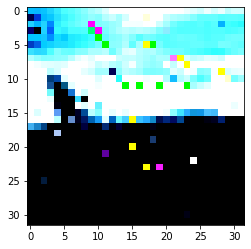

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


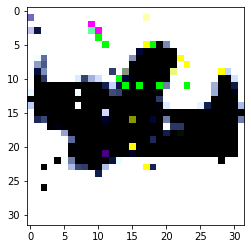

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


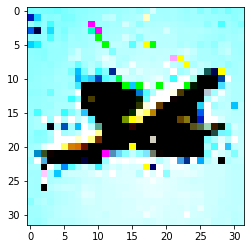

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


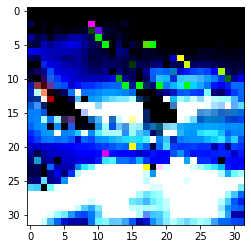

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


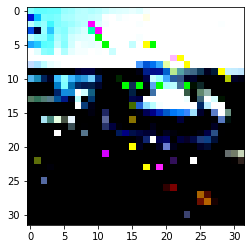

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


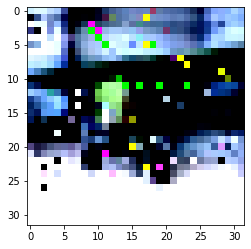

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


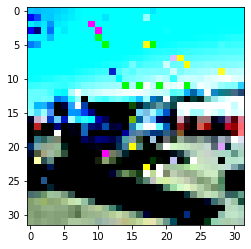

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


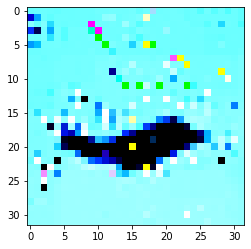

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


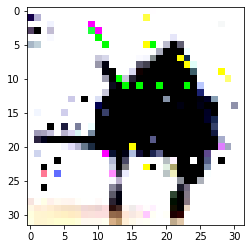

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


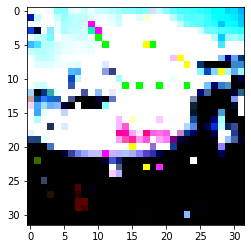

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


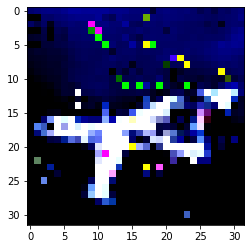

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


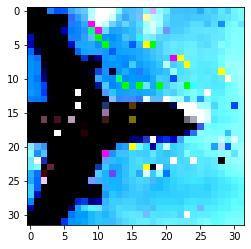

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


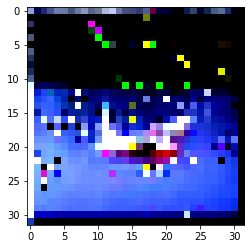

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


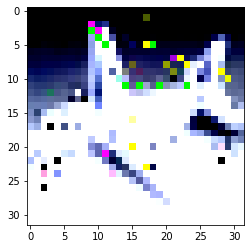

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


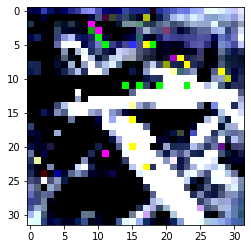

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


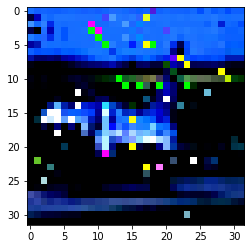

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


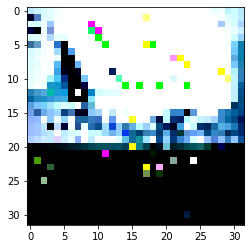

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


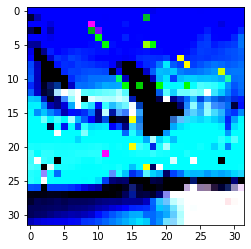

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


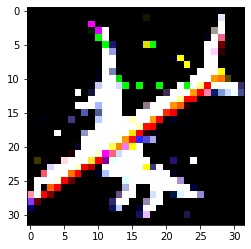

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


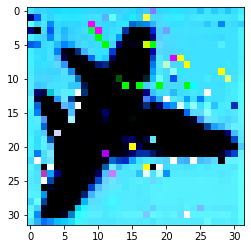

test acc: 20.28%
==> Preparing data..
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


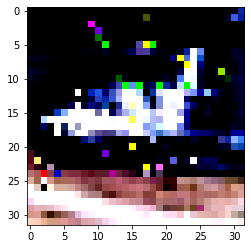

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


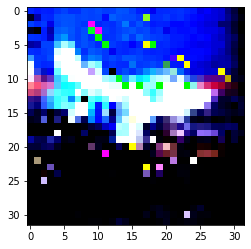

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


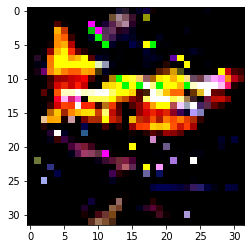

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


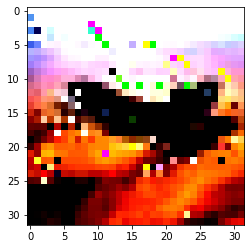

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


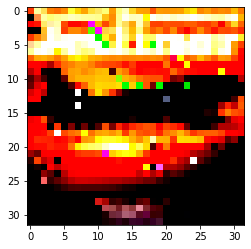

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


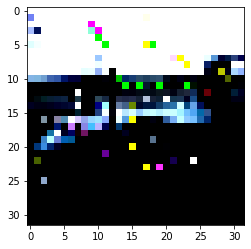

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


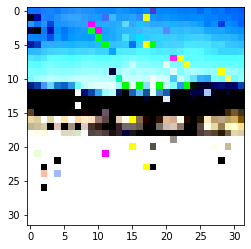

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


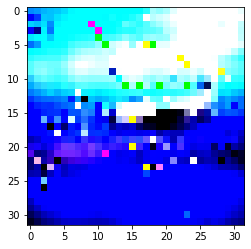

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


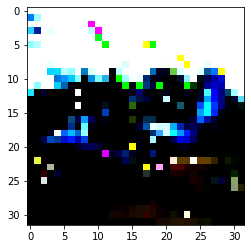

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


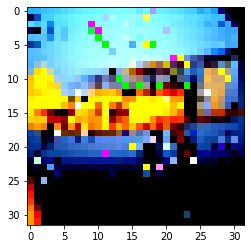

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


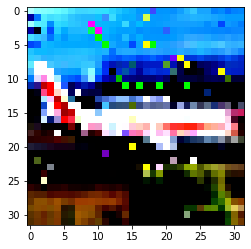

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


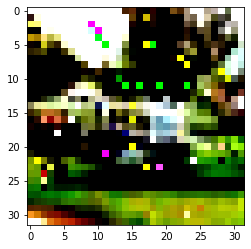

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


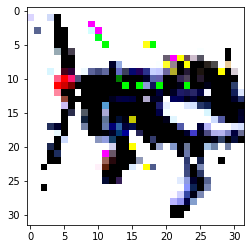

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


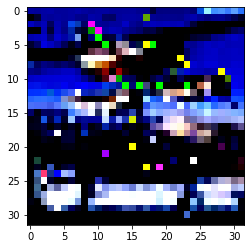

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


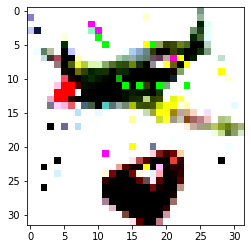

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


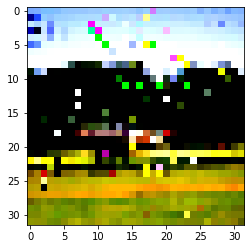

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


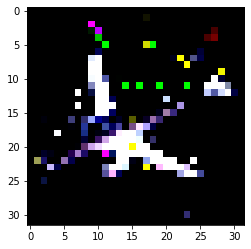

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


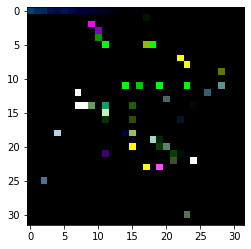

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


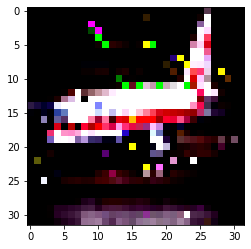

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


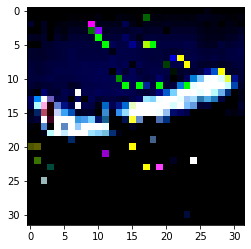

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


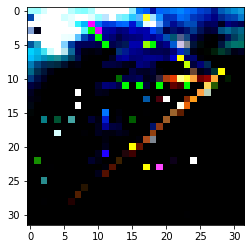

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


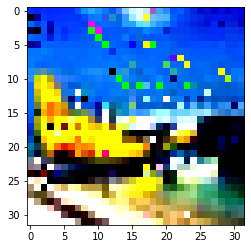

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


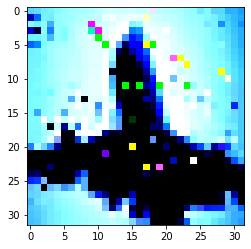

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


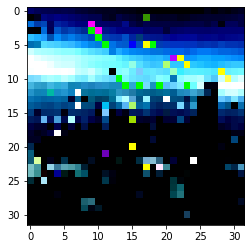

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


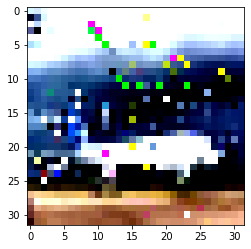

test acc: 66.64%
==> Preparing data..
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


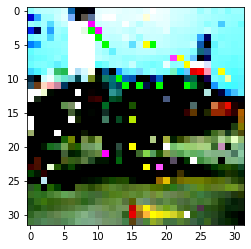

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


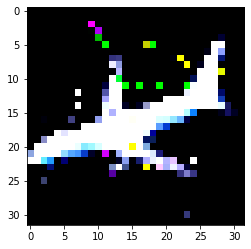

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


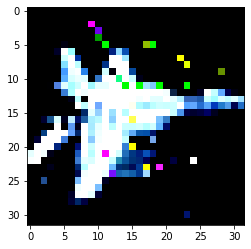

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


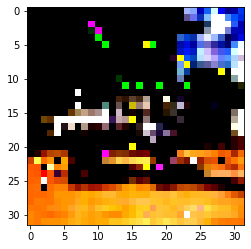

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


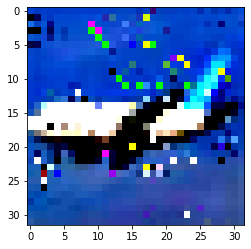

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


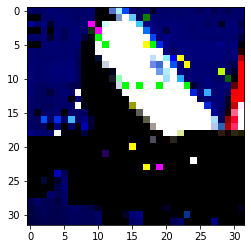

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


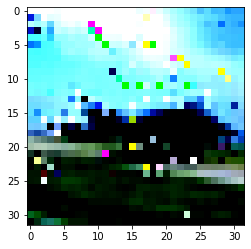

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


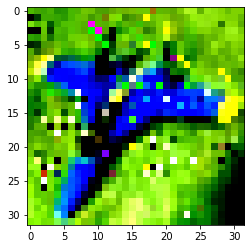

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


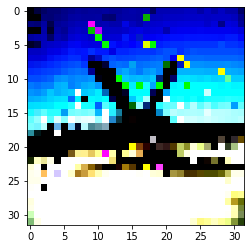

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


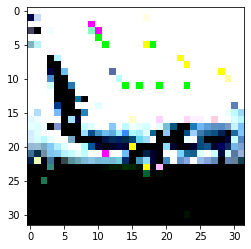

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


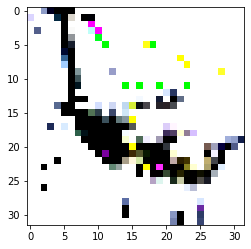

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


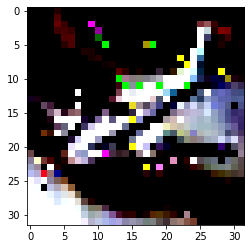

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


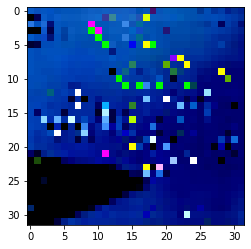

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


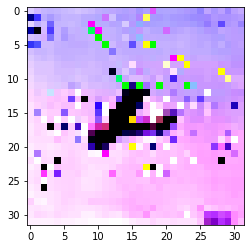

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


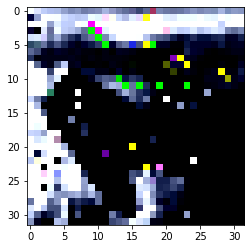

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


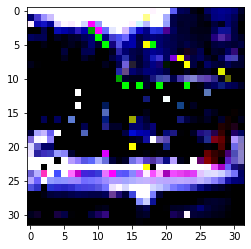

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


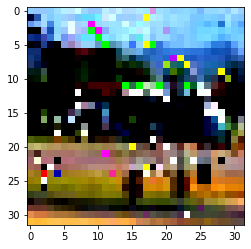

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


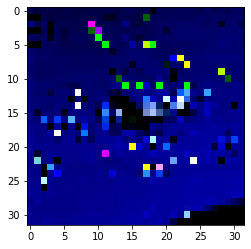

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


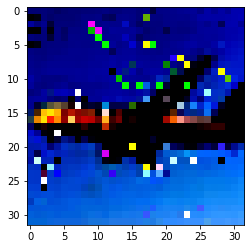

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


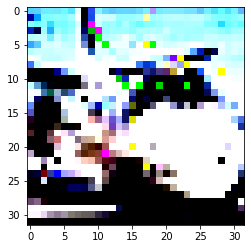

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


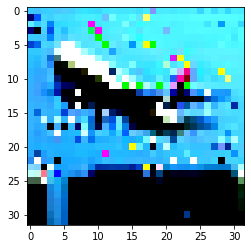

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


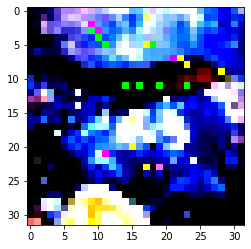

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


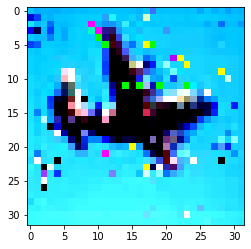

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


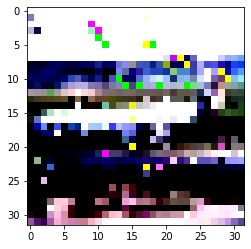

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


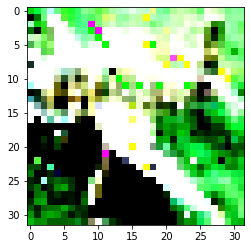

test acc: 13.30%
==> Preparing data..
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


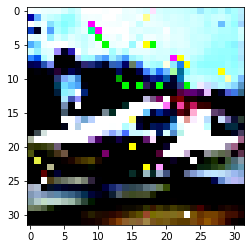

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


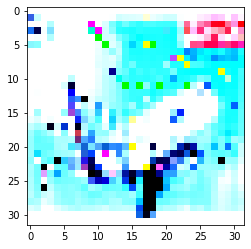

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


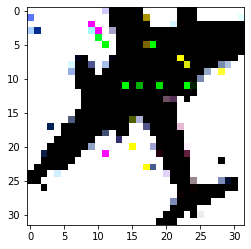

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


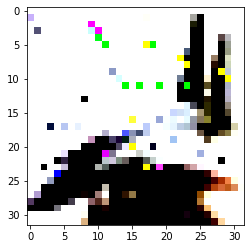

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


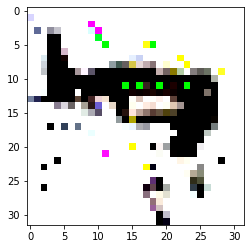

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


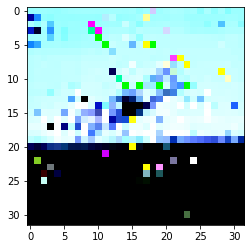

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


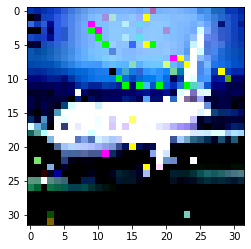

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


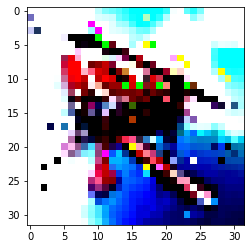

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


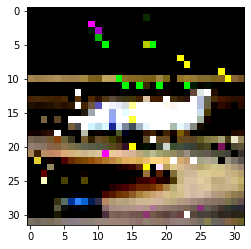

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


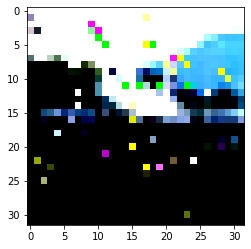

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


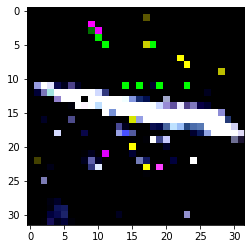

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


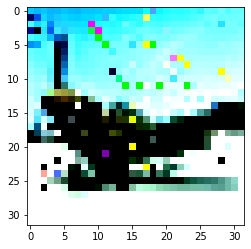

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


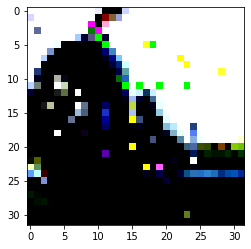

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


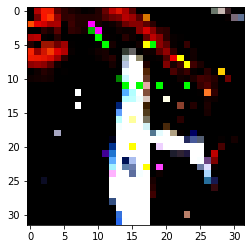

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


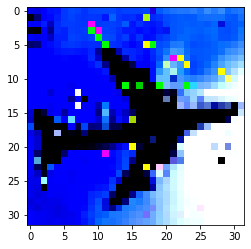

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


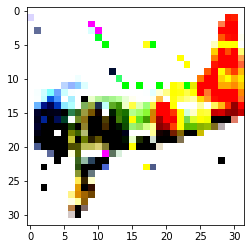

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


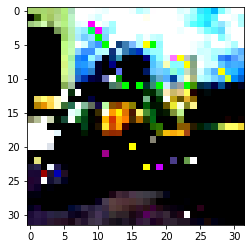

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


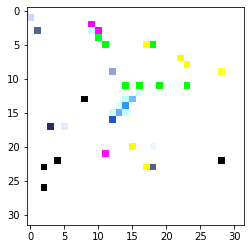

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


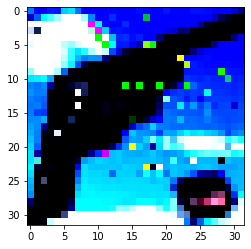

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


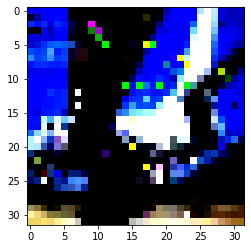

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


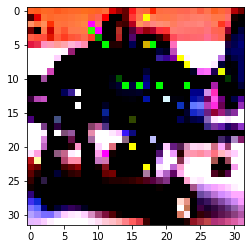

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


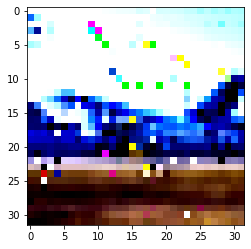

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


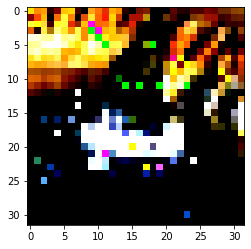

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


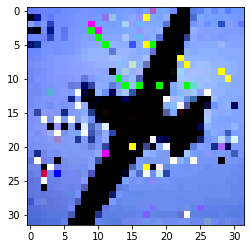

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


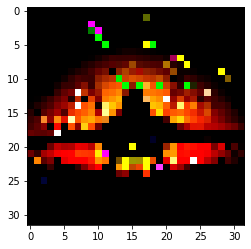

test acc: 3.96%


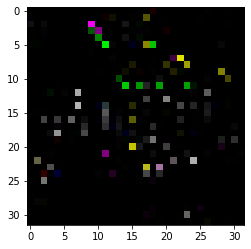

In [7]:
mask, pattern = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_advtroj.pth')
mask, pattern = load_pattern()
new_test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj.pth')
new_test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj2.pth')
new_test(mask, pattern, source_label=0, target_label=9, model_path='models/p_troj.pth')
new_test(mask, pattern, source_label=0, target_label=9, model_path='models/p_troj2.pth')
new_test(mask, pattern, source_label=0, target_label=9, model_path='models/benign.pth')

att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()